# Problema 50
## 50)
Utilizaremos un código **Particle Mesh** suavizando a las partículas con **NGP** para integrar el movimiento de 2 $e^-$ en un box periódico 1-dimensional de lado $L=64$, dividido en $N=64$ celdas de ancho $\Delta = \frac{L}{N} = 1$, utilizando técnicas *Multigrid* para el cálculo del potencial eléctrico en cada celda:
### <center> $\Delta \phi = \frac{-\rho(\vec x)}{\epsilon_0}$ </center>
### <center> $(\frac{\partial^2 \phi}{\partial x^2})_i \approx \frac{\phi_{i+1}-2\phi_i+\phi_{i-1}}{\Delta^2} \approx \frac{-\rho_i}{\epsilon_0}$ </center>
Luego, esto se tiene la forma de una matriz tridiagonal (que sabemos resolver) y obtenemos la aceleración sobre cada celda de la forma:
### <center> $-\triangledown \phi = \vec a$ </center>
### <center> $-\frac{\phi_{i+1} -\phi_{i-1}}{2\Delta} \approx a_{x,i}$ </center>
Una vez obtenida la aceleración de cada partícula, resta aplicar **LF-KDK** y obtener las nuevas posiciones de las partículas, con un paso en el tiempo de $h$ a lo largo del tiempo $t = 3$ períodos.

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

n = 10000 #Cant de pasos
h = 1 #¿Intervalo de tiempo?
c = 64 #L
p = np.arange(0,c) #Celdas (acá decimos que la d entre celdas es = 1)
x = np.zeros((n,2)) #pos 1,2 para todo t (columna i => part i)
x[0,0] = 3*c/8
x[0,1] = 5*c/8 #Posc inic (las corro de los bordes)

#Poisson: phi'' = -rho/e0 => Tridiag: (phi_i)'' = (phi_i-1 + phi_i+1 - 2phi_i)/(1/64^2) = -rho_i/e0

tri = np.zeros((len(p),len(p))) #La matriz de coef tridiag (fija)
for i in range(len(p)):
    if i == 0:
        tri[i,i] = -2
        tri[i,i+1] = 1
        tri[i,i-1] = 1
    elif i != len(p)-1:
        tri[i,i] = -2
        tri[i,i+1] = 1
        tri[i,i-1] = 1
    else:
        tri[i,i] = -2
        tri[i,i-1] = 1
        tri[i,0] = 1
        
#Calculo a:
#Vemos que se come a px y a phi (2 cosas que hay que actualizar por paso)

def a(px,phi):
    a = np.zeros(2) #una a según la celda, por NGP (sino tendría que interpolar), 1 a por partícula
    j = 0 #Contador
    for i in range(len(px)):
        
        if px[i] != 0: #Si hay un part en la celda...
            #print(i)
            if i != len(p)-1:
                a[j] = -(phi[i+1] - phi[i-1])/2 #interpolo lo que se va a aplicar a la partícula
                a[j+1] = -a[j]
                j += 2
            else:
                a[j] = -(phi[0] - phi[i-1])/2
                a[j+1] = -a[j]
                j += 2
        if j == 2:
            break

    return a

def LF_KDK(a=a,x=x,p=p,h=h,n=n,vx=[0,0]):
    
    for l in range(n-1):
        
        if x[l,0] > c or x[l,0] < 0:
            x[l,0] = x[l,0] % c
        if x[l,1] > c or x[l,1] < 0:
            x[l,1] = x[l,1] % c #Periodicidad
    
        px = np.zeros(len(p)) #Cant de part en cada celda
        for i in range(len(p)):
            for j in range(2):
                if i <= x[l,j] < (i+1):
                    px[i] += 1
                    
        #print(px)

        #A rho hay que actualizarla, para actualizar a phi

        rho = -4*np.pi*6.67e-6*px #q del e- sobre la permisividad del vacío
        #print(rho)
        
        phi = LA.solve(tri,rho)
        #print(phi)

        #Una vez conseguido phi, evolucionemos a c/ partícula:
        
        if x[l,0] < x[l,1]:
            A,B = 0,1
        else:
            B,A = 0,1
        
        kx0 = vx[A] + a(px,phi)[A]*h/2
        kx1 = vx[B] + a(px,phi)[B]*h/2

        x[l+1,A] = x[l,A] + kx0*h
        x[l+1,B] = x[l,B] + kx1*h

        vx[A] = kx0 + a(px,phi)[A]*h/2
        vx[B] = kx1 + a(px,phi)[B]*h/2
        
        if l%100 == 0:
        
            plt.figure(figsize=(13,13))
            plt.scatter([x[l,0],x[l,1]],[0,0],c=['r','b'],label='$e^{-}$')
            plt.legend(loc='upper left',shadow=True,fontsize=15)
            plt.xticks([8*i for i in range(8)],fontsize=15)
            plt.yticks([0],fontsize=15)
            plt.xlabel('x',fontsize=20)
            plt.grid(True)
            plt.xlim(0,c)
            plt.savefig(f'PM_{l}.jpg')
            plt.close()
        
    return x

In [78]:
#x = LF_KDK()

Graficamos las trayectorias a lo largo del tiempo, y dejamos la animación del movimiento de ambas partículas en

https://drive.google.com/file/d/1s-MLk_0rOgdlJC71GKtymlTYlHrrLt9l/view?usp=sharing

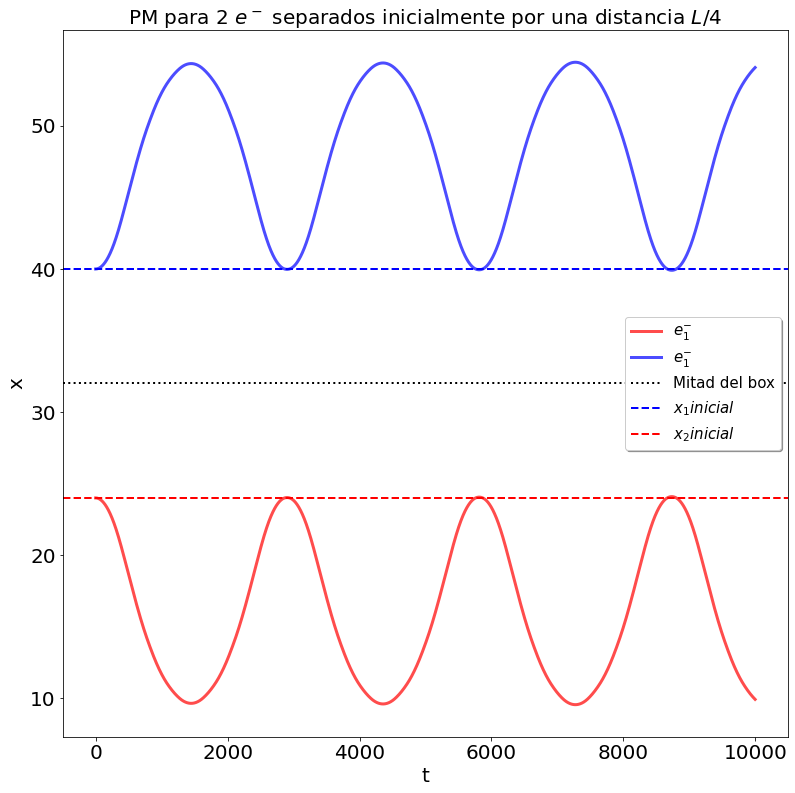

In [79]:
plt.figure(figsize=(13,13))
plt.title('PM para 2 $e^-$ separados inicialmente por una distancia $L/4$',fontsize=20)
plt.plot([i for i in range(len(x[:,0])-1)],x[:-1,0],alpha=0.7,label='$e^{-}_1$',c='r',lw=3)
plt.plot([i for i in range(len(x[:,1])-1)],x[:-1,1],alpha=0.7,label='$e^{-}_1$',c='b',lw=3)
plt.axhline(32,ls=':',lw=2,label='Mitad del box',c='k')
plt.axhline(40,ls='--',lw=2,label='$x_1 inicial$',c='b')
plt.axhline(24,ls='--',lw=2,label='$x_2 inicial$',c='r')
plt.xlabel('t',fontsize=20)
plt.ylabel('x',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',shadow=True,fontsize=15);